# Лабораторная работа 6. Логистическая регрессия

## Импорт необходимых библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter

## Загрузка данных

In [2]:
df = pd.read_csv("train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Распределение целевой переменной Survived


In [6]:
df["Survived"].value_counts()

,count
Survived,
0,549
1,342


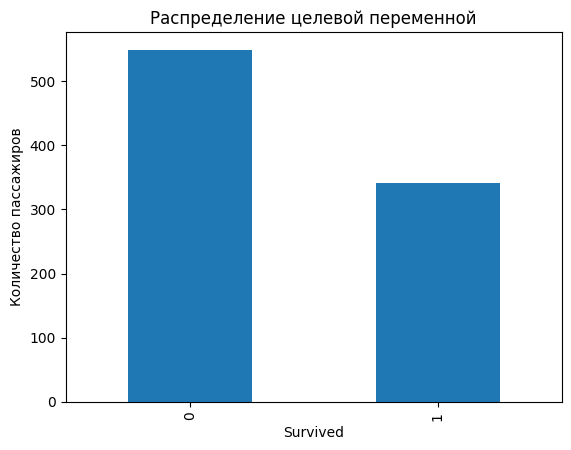

In [8]:
df["Survived"].value_counts().plot(kind="bar")
plt.title("Распределение целевой переменной")
plt.xlabel("Survived")
plt.ylabel("Количество пассажиров")
plt.show()

## Статистика и визуализация

In [4]:
df.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Dooley, Mr. Patrick",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


### Гистограммы некоторых числовых признаков


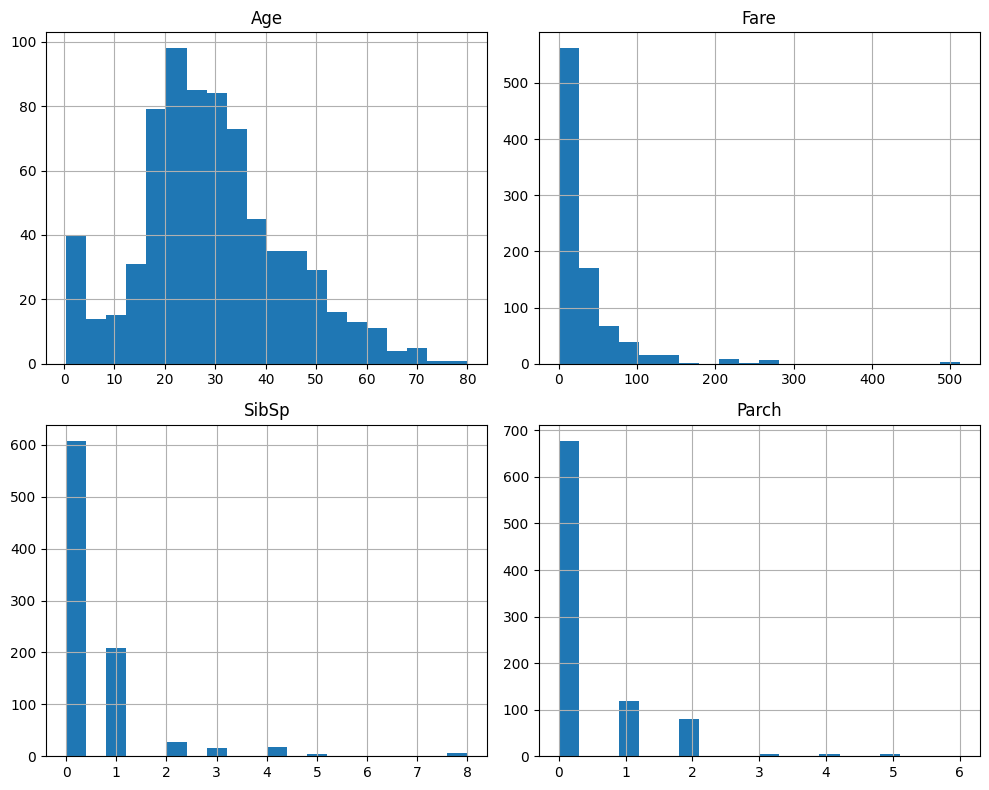

In [5]:
numeric_cols = ["Age", "Fare", "SibSp", "Parch"]
df[numeric_cols].hist(bins=20, figsize=(10, 8))
plt.tight_layout()
plt.show()

### Зависимость выживаемости от класса и пола


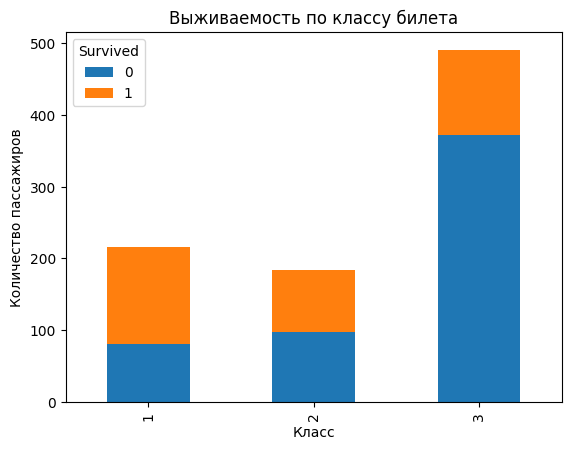

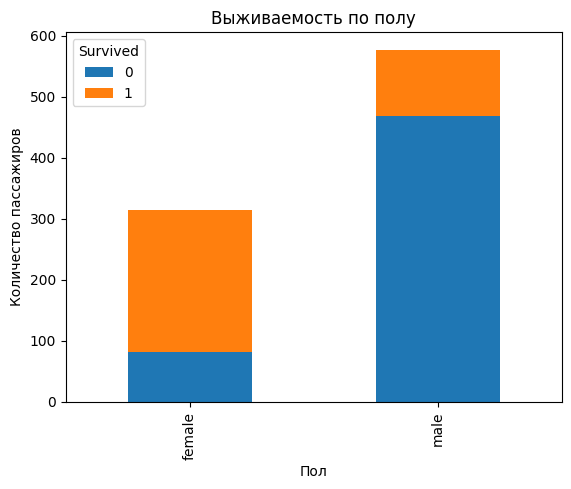

In [11]:
pd.crosstab(df["Pclass"], df["Survived"]).plot(kind="bar", stacked=True)
plt.title("Выживаемость по классу билета")
plt.xlabel("Класс")
plt.ylabel("Количество пассажиров")
plt.show()

pd.crosstab(df["Sex"], df["Survived"]).plot(kind="bar", stacked=True)
plt.title("Выживаемость по полу")
plt.xlabel("Пол")
plt.ylabel("Количество пассажиров")
plt.show()

## Предварительная обработка данных

In [12]:
features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
target_col = "Survived"

data = df[features + [target_col]].copy()
data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,male,22.0,1,0,7.2500,S,0
1,1,female,38.0,1,0,71.2833,C,1
2,3,female,26.0,0,0,7.9250,S,1
3,1,female,35.0,1,0,53.1000,S,1
4,3,male,35.0,0,0,8.0500,S,0


### Обработка пропущенных значений

In [13]:
data["Age"] = data["Age"].fillna(data["Age"].median())
data["Embarked"] = data["Embarked"].fillna(data["Embarked"].mode()[0])
data["Fare"] = data["Fare"].fillna(data["Fare"].median())

data.isnull().sum()

,0
Pclass,0
Sex,0
Age,0
SibSp,0
Parch,0
Fare,0
Embarked,0
Survived,0


### Кодирование категориальных признаков

In [14]:
data_encoded = pd.get_dummies(
    data,
    columns=["Sex", "Embarked"],
    drop_first=True
)

data_encoded.head()

,Pclass,Age,SibSp,Parch,Fare,Survived,Sex_male,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,True,False,True
1,1,38.0,1,0,71.2833,1,False,False,False
2,3,26.0,0,0,7.9250,1,False,False,True
3,1,35.0,1,0,53.1000,1,False,False,True
4,3,35.0,0,0,8.0500,0,True,False,True


In [15]:
# разделение на признаки (X) и целевую переменную (y)
X_all = data_encoded.drop(columns=[target_col])
y_all = data_encoded[target_col].values

X_all.head(), y_all[:10]

(   Pclass   Age  SibSp  Parch     Fare  Sex_male  Embarked_Q  Embarked_S
 0       3  22.0      1      0   7.2500      True       False        True
 1       1  38.0      1      0  71.2833     False       False       False
 2       3  26.0      0      0   7.9250     False       False        True
 3       1  35.0      1      0  53.1000     False       False        True
 4       3  35.0      0      0   8.0500      True       False        True,
 array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1]))

## Разделение на обучающую и тестовую выборки

In [16]:
def train_test_split_custom(X: pd.DataFrame, y: np.ndarray, test_size: float = 0.2, seed: int = 42):
    np.random.seed(seed)
    n = len(X)
    indices = np.random.permutation(n)
    test_count = int(n * test_size)

    test_idx = indices[:test_count]
    train_idx = indices[test_count:]

    X_train = X.iloc[train_idx].reset_index(drop=True)
    X_test = X.iloc[test_idx].reset_index(drop=True)
    y_train = y[train_idx]
    y_test = y[test_idx]

    return X_train, X_test, y_train, y_test

X_train_df, X_test_df, y_train, y_test = train_test_split_custom(X_all, y_all, test_size=0.2, seed=42)
X_train_df.shape, X_test_df.shape

((713, 8), (178, 8))

## Масштабирование признаков

In [17]:
def standardize_fit(X_df: pd.DataFrame):
    X_num = X_df.astype(float)
    mean = X_num.mean()
    std = X_num.std(ddof=0).replace(0, 1)  # защита от деления на 0
    X_scaled = (X_num - mean) / std
    return X_scaled, mean, std

def standardize_transform(X_df: pd.DataFrame, mean: pd.Series, std: pd.Series):
    X_num = X_df.astype(float)
    return (X_num - mean) / std

In [18]:
X_train_scaled_df, mean_X, std_X = standardize_fit(X_train_df)
X_test_scaled_df = standardize_transform(X_test_df, mean_X, std_X)

X_train_scaled_df.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0.812087,-1.932505,0.379618,0.783811,-0.305665,-1.377815,-0.303123,0.591928
1,-1.615661,1.253941,-0.471538,-0.480572,-0.078304,0.725787,-0.303123,0.591928
2,-0.401787,-0.473650,-0.471538,-0.480572,-0.376956,0.725787,-0.303123,0.591928
3,0.812087,0.217386,-0.471538,-0.480572,-0.474740,0.725787,-0.303123,0.591928
4,0.812087,-0.243305,0.379618,-0.480572,-0.476104,0.725787,-0.303123,0.591928


In [19]:
def add_intercept(X: np.ndarray):
    return np.c_[np.ones((X.shape[0], 1)), X]

X_train = add_intercept(X_train_scaled_df.values)
X_test = add_intercept(X_test_scaled_df.values)

X_train.shape, X_test.shape

((713, 9), (178, 9))

## Реализация логистической регрессии

In [20]:
def sigmoid(z: np.ndarray) -> np.ndarray:
    z = np.clip(z, -500, 500)
    return 1.0 / (1.0 + np.exp(-z))


def log_loss(y_true: np.ndarray, y_pred_proba: np.ndarray) -> float:
    eps = 1e-15
    p = np.clip(y_pred_proba, eps, 1 - eps)
    loss = -np.mean(y_true * np.log(p) + (1 - y_true) * np.log(1 - p))
    return loss

In [21]:
def train_logreg_gd(X: np.ndarray, y: np.ndarray, learning_rate: float = 0.1, n_iters: int = 1000):
    n_samples, n_features = X.shape
    theta = np.zeros(n_features)
    losses = []

    for i in range(n_iters):
        z = X @ theta
        y_pred = sigmoid(z)
        grad = (X.T @ (y_pred - y)) / n_samples
        theta -= learning_rate * grad

        if i % 10 == 0 or i == n_iters - 1:
            loss = log_loss(y, y_pred)
            losses.append(loss)

    return theta, losses

In [22]:
def train_logreg_newton(X: np.ndarray, y: np.ndarray, n_iters: int = 20):
    n_samples, n_features = X.shape
    theta = np.zeros(n_features)
    losses = []

    for i in range(n_iters):
        z = X @ theta
        p = sigmoid(z)

        grad = (X.T @ (p - y)) / n_samples

        w = p * (1 - p)
        X_weighted = X * w[:, np.newaxis]
        H = (X.T @ X_weighted) / n_samples

        H_inv = np.linalg.pinv(H)
        theta -= H_inv @ grad

        loss = log_loss(y, p)
        losses.append(loss)

    return theta, losses

In [23]:
def predict_proba_logreg(X: np.ndarray, theta: np.ndarray) -> np.ndarray:
    return sigmoid(X @ theta)


def predict_logreg(X: np.ndarray, theta: np.ndarray, threshold: float = 0.5) -> np.ndarray:
    proba = predict_proba_logreg(X, theta)
    return (proba >= threshold).astype(int)

In [24]:
def confusion_matrix_binary(y_true: np.ndarray, y_pred: np.ndarray):
    cm = np.zeros((2, 2), dtype=int)
    for yt, yp in zip(y_true, y_pred):
        cm[int(yt), int(yp)] += 1
    return cm

def accuracy_score_manual(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return np.mean(y_true == y_pred)

def precision_recall_f1_from_cm(cm: np.ndarray):
    TN, FP = cm[0, 0], cm[0, 1]
    FN, TP = cm[1, 0], cm[1, 1]
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    if precision + recall > 0:
        f1 = 2 * precision * recall / (precision + recall)
    else:
        f1 = 0.0
    return precision, recall, f1

## Базовая модель логистической регрессии

In [25]:
learning_rate = 0.1
n_iters = 1000

theta_gd, losses_gd = train_logreg_gd(X_train, y_train, learning_rate=learning_rate, n_iters=n_iters)
theta_gd

array([-0.67399883, -0.79903186, -0.41192007, -0.35866683, -0.10003008,
        0.12508019, -1.29794527, -0.04830125, -0.18979309])

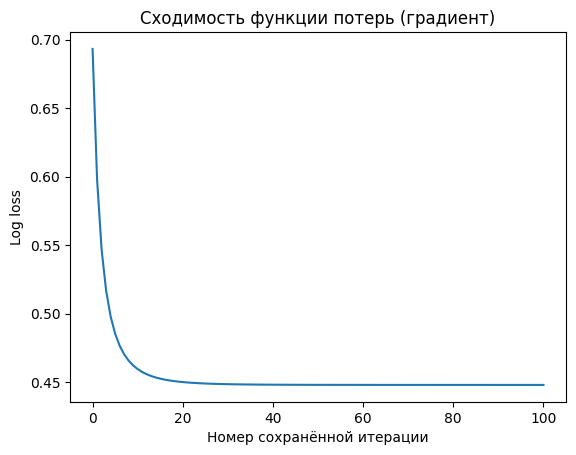

In [26]:
plt.plot(losses_gd)
plt.title("Сходимость функции потерь (градиент)")
plt.xlabel("Номер сохранённой итерации")
plt.ylabel("Log loss")
plt.show()

In [27]:
y_pred_gd = predict_logreg(X_test, theta_gd, threshold=0.5)
cm_gd = confusion_matrix_binary(y_test, y_pred_gd)
cm_gd

array([[90, 15],
       [19, 54]])

In [28]:
acc_gd = accuracy_score_manual(y_test, y_pred_gd)
prec_gd, rec_gd, f1_gd = precision_recall_f1_from_cm(cm_gd)

print(f"Gradient Descent (lr={learning_rate}, iters={n_iters})")
print(f"Accuracy:  {acc_gd:.4f}")
print(f"Precision: {prec_gd:.4f}")
print(f"Recall:    {rec_gd:.4f}")
print(f"F1-score:  {f1_gd:.4f}")

Gradient Descent (lr=0.1, iters=1000)
Accuracy:  0.8090
Precision: 0.7826
Recall:    0.7397
F1-score:  0.7606


## Модель логистической регрессии (Ньютон)

In [29]:
n_iters_newton = 15

theta_newton, losses_newton = train_logreg_newton(X_train, y_train, n_iters=n_iters_newton)
theta_newton

array([-0.67463269, -0.80153171, -0.41292479, -0.35882772, -0.09942496,
        0.12291912, -1.29831571, -0.04784767, -0.18990518])

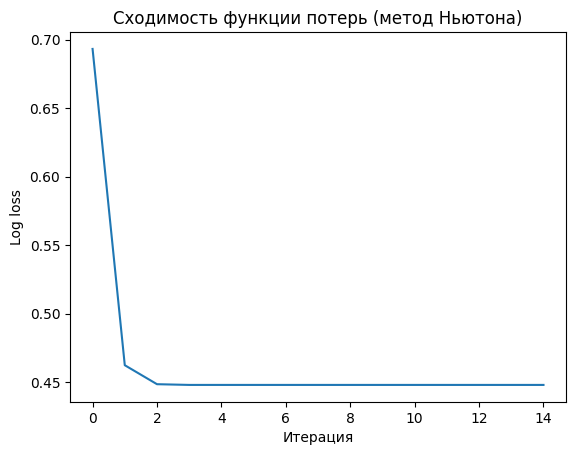

In [30]:
plt.plot(losses_newton)
plt.title("Сходимость функции потерь (метод Ньютона)")
plt.xlabel("Итерация")
plt.ylabel("Log loss")
plt.show()

In [31]:
y_pred_newton = predict_logreg(X_test, theta_newton, threshold=0.5)
cm_newton = confusion_matrix_binary(y_test, y_pred_newton)
cm_newton

array([[90, 15],
       [19, 54]])

In [32]:
acc_n = accuracy_score_manual(y_test, y_pred_newton)
prec_n, rec_n, f1_n = precision_recall_f1_from_cm(cm_newton)

print(f"Newton's method (iters={n_iters_newton})")
print(f"Accuracy:  {acc_n:.4f}")
print(f"Precision: {prec_n:.4f}")
print(f"Recall:    {rec_n:.4f}")
print(f"F1-score:  {f1_n:.4f}")

Newton's method (iters=15)
Accuracy:  0.8090
Precision: 0.7826
Recall:    0.7397
F1-score:  0.7606


## Исследование гиперпараметров


In [33]:
results = []

learning_rates = [0.01, 0.05, 0.1]
n_iters_list_gd = [300, 600, 1000]
n_iters_list_newton = [5, 10, 20]

# Градиентный спуск
for lr in learning_rates:
    for n_it in n_iters_list_gd:
        theta, _ = train_logreg_gd(X_train, y_train, learning_rate=lr, n_iters=n_it)
        y_pred = predict_logreg(X_test, theta, threshold=0.5)
        cm = confusion_matrix_binary(y_test, y_pred)
        acc = accuracy_score_manual(y_test, y_pred)
        prec, rec, f1 = precision_recall_f1_from_cm(cm)

        results.append({
            "method": "gradient_descent",
            "learning_rate": lr,
            "n_iters": n_it,
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1": f1
        })

# Метод Ньютона
for n_it in n_iters_list_newton:
    theta, _ = train_logreg_newton(X_train, y_train, n_iters=n_it)
    y_pred = predict_logreg(X_test, theta, threshold=0.5)
    cm = confusion_matrix_binary(y_test, y_pred)
    acc = accuracy_score_manual(y_test, y_pred)
    prec, rec, f1 = precision_recall_f1_from_cm(cm)

    results.append({
        "method": "newton",
        "learning_rate": None,
        "n_iters": n_it,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    })

results_df = pd.DataFrame(results)
results_df

,method,learning_rate,n_iters,accuracy,precision,recall,f1
0,gradient_descent,0.01,300,0.775281,0.720000,0.739726,0.729730
1,gradient_descent,0.01,600,0.780899,0.729730,0.739726,0.734694
2,gradient_descent,0.01,1000,0.786517,0.746479,0.726027,0.736111
3,gradient_descent,0.05,300,0.786517,0.753623,0.712329,0.732394
4,gradient_descent,0.05,600,0.797753,0.776119,0.712329,0.742857
5,gradient_descent,0.05,1000,0.803371,0.779412,0.726027,0.751773
6,gradient_descent,0.10,300,0.797753,0.776119,0.712329,0.742857
7,gradient_descent,0.10,600,0.808989,0.782609,0.739726,0.760563
8,gradient_descent,0.10,1000,0.808989,0.782609,0.739726,0.760563
9,newton,NaN,5,0.808989,0.782609,0.739726,0.760563


### Сортировка комбинации по F1-score (от лучшей к худшей)

In [34]:
results_df_sorted = results_df.sort_values(by="f1", ascending=False)
results_df_sorted

,method,learning_rate,n_iters,accuracy,precision,recall,f1
8,gradient_descent,0.10,1000,0.808989,0.782609,0.739726,0.760563
9,newton,NaN,5,0.808989,0.782609,0.739726,0.760563
10,newton,NaN,10,0.808989,0.782609,0.739726,0.760563
7,gradient_descent,0.10,600,0.808989,0.782609,0.739726,0.760563
11,newton,NaN,20,0.808989,0.782609,0.739726,0.760563
5,gradient_descent,0.05,1000,0.803371,0.779412,0.726027,0.751773
6,gradient_descent,0.10,300,0.797753,0.776119,0.712329,0.742857
4,gradient_descent,0.05,600,0.797753,0.776119,0.712329,0.742857
2,gradient_descent,0.01,1000,0.786517,0.746479,0.726027,0.736111
1,gradient_descent,0.01,600,0.780899,0.729730,0.739726,0.734694
